# A Simple Neural Network

Now we have an understanding of how models learn, let's make a simple neural network. Again, we will do so in vanilla Python to get a stronger awareness of the key concepts before we learn the relative ease of using PyTorch.

We can also start looking at some real data! The canonical starter for many ML adventures is the MNIST dataset, which comprises black and white images of hand-drawn digits between 0-9.

In [3]:
!pip install scikit-learn --quiet

### Import Data

Firstly, here is a simple function to import the dataset. We will use scikit-learn, a popular scientific programming library for Python which also comprises the MNIST and other datasets.

Notice we split the dataset of images into `train` and `test` sets. The majority of images are used to train the model, some are held back to test it. The `X` refers to the training and testing images, the `y` to the respective labels (0, 1, 2 etc).


In [4]:
from sklearn.datasets import fetch_openml
import numpy as np
import random

def load_mnist_sample(n_samples=5000):
    """Load a sample of MNIST data for quick experimentation"""
    print("Loading MNIST data...")

    # Load MNIST from sklearn
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    X, y = mnist.data, mnist.target.astype(int)

    # Take a random sample for faster training
    indices = random.sample(range(len(X)), min(n_samples, len(X)))
    X_sample = X.iloc[indices].values if hasattr(X, 'iloc') else X[indices]
    y_sample = y[indices]

    # Normalize pixel values to [0, 1]
    X_sample = X_sample / 255.0

    # Convert labels to one-hot encoding
    y_onehot = np.zeros((len(y_sample), 10))
    y_onehot[np.arange(len(y_sample)), y_sample] = 1

    # Split into train and test
    split_idx = int(0.8 * len(X_sample))
    X_train, X_test = X_sample[:split_idx], X_sample[split_idx:]
    y_train, y_test = y_onehot[:split_idx], y_onehot[split_idx:]

    print("MNIST data downloaded")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_mnist_sample(n_samples=5000)

Loading MNIST data...
MNIST data downloaded


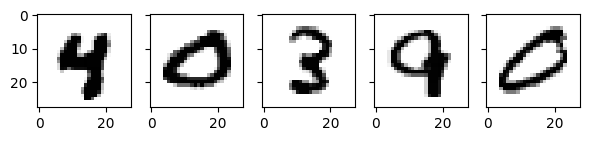

In [5]:
import matplotlib.pyplot as plt
# Display a few random MNIST digits from your training set
fig, axs = plt.subplots(1, 5, figsize=(7, 4), sharex=True, sharey=True)
# Set parameters for subplot (num_rows, num_cols, figure size etc.)

for i in range(5):    # Iterate over a few images to display
    axs[i].imshow(X_train[i].reshape(28, 28), cmap='binary')   # Reshape the image from (784,) array format into an 28x28 grid


### What exactly is our dataset?

Our images of hand-drawn numbers are just arrays of pixel values, showing various floats depending on whether the pixel is pure white, black, or in between.

If we check the type, we see we are working with a Numpy array.

In [6]:
type(X_train)

numpy.ndarray

There are 784 values for each image. Notice when we print the array that many values are 0., this indicates white / blank space around the image.

In [7]:
len(X_train[1])

784

In [8]:
X_train[1][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Making a Neural Network

Our code will make some changes to the QuadraticModel class.
We will also use a new loss function,
**Cross entropy**, which is a good choice for classification tasks (whereas MSE
can be best for regression). Cross entropy loss measures how far our predicted probability distribution is from the true distribution.

Another new feature is **one hot encoding**. This is a method of representing categorical data (digits 0-9 in this case) as binary vectors.
0 is represented as [1,0,0,0,0,0,0,0,0,0]
1 is [0,1,0,0,0,0,0,0,0,0]
2 is [0,0,1,0,0,0,0,0,0,0] etc.

We also use a **softmax** function in the output layer to produce a probability distribution over all classes, outputting values that sum to 1.
So if we test the model on a handwritten '2', its output would be:

**0**: 0.1

**1**: 0.3

**2**: 0.9

**3**: 0.3

etc, with 2 as the obvious favourite.

In [14]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import random

class SimpleNeuralNetwork:
    """
    A simple neural network implementation to emphasize core concepts.
    """

    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        Initialize the neural network.

        Args:
            layer_sizes: List of integers representing the size of each layer
                        e.g., [784, 128, 64, 10] for MNIST
            learning_rate: Step size for gradient descent
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)

        # Initialize weights and biases using small random values
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            # Xavier initialization for better convergence
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))

            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self, x):
        """Sigmoid activation function - squashes values between 0 and 1"""
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        """ReLU activation function - sets negative values to 0"""
        return np.maximum(0, x)

    def relu_derivative(self, x):
        """Derivative of ReLU function"""
        return (x > 0).astype(float)

    def softmax(self, x):
        """Softmax activation for output layer - converts to probabilities"""
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward_pass(self, X):
        """
        Making predictions!
        Forward propagation through the network, where we feed data through
        layer by layer.
        Each layer transforms the input using weights and biases, then applies an
        activation function, so output = activation(input @ weights + bias)
        The final layer gives us probabilities for each class.
        """
        self.activations = [X]  # Store activations for backprop
        self.z_values = []      # Store pre-activation values

        current_input = X

        # Go through each layer
        for i in range(len(self.weights)):
            # Linear transformation: z = input @ weights + bias
            z = current_input @ self.weights[i] + self.biases[i]
            self.z_values.append(z)

            # Apply activation function
            if i == len(self.weights) - 1:  # Output layer
                activation = self.softmax(z)
            else:  # Hidden layers
                activation = self.relu(z)

            self.activations.append(activation)
            current_input = activation

        return self.activations[-1]  # Return final output

    def compute_loss(self, predictions, true_labels):
        """
        Compute cross-entropy loss.
        L = -[y*log(p) + (1-y)*log(1-p)]
        This measures how wrong our predictions are.
        Lower loss = better predictions!
        """
        # Avoid log(0) by adding small epsilon
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        # Cross-entropy loss
        loss = -np.mean(np.sum(true_labels * np.log(predictions), axis=1))
        return loss

    def backward_pass(self, true_labels):
        """
        Backpropagation - calculate how much each weight contributed
        to the error, adjust weights to reduce that error.
        """
        batch_size = true_labels.shape[0]

        # Start with the output layer error
        # This is the derivative of loss with respect to output
        output_error = self.activations[-1] - true_labels

        # Store gradients for weights and biases
        weight_gradients = []
        bias_gradients = []

        # Work backwards through the layers
        current_error = output_error

        for i in reversed(range(len(self.weights))):
            # Gradient for weights: previous_activation^T @ current_error
            weight_grad = self.activations[i].T @ current_error / batch_size
            weight_gradients.insert(0, weight_grad)

            # Gradient for biases: mean of current_error
            bias_grad = np.mean(current_error, axis=0, keepdims=True)
            bias_gradients.insert(0, bias_grad)

            # If not the first layer, compute error for previous layer
            if i > 0:
                # Error propagates backwards: current_error @ weights^T
                error_from_next = current_error @ self.weights[i].T

                # Apply derivative of activation function
                activation_derivative = self.relu_derivative(self.z_values[i-1])
                current_error = error_from_next * activation_derivative

        return weight_gradients, bias_gradients

    def update_parameters(self, weight_gradients, bias_gradients):
        """
        Gradient descent update step.

        We adjust weights in the opposite direction of the gradient
        to minimize the loss function.
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]

    def train_batch(self, X, y):
        """Train on a single batch of data"""
        # Forward pass: make predictions
        predictions = self.forward_pass(X)

        # Compute loss: how wrong are we?
        loss = self.compute_loss(predictions, y)

        # Backward pass: calculate gradients
        weight_grads, bias_grads = self.backward_pass(y)

        # Update parameters: improve the weights
        self.update_parameters(weight_grads, bias_grads)

        return loss

    def predict(self, X):
        """Make predictions on new data"""
        return self.forward_pass(X)

    def accuracy(self, X, y):
        """Calculate accuracy on a dataset"""
        predictions = self.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y, axis=1)
        return np.mean(predicted_classes == true_classes)



Our model looks like this:
```
 Input     Hidden1    Hidden2    Output
  784  →    128   →    64   →    10
   ●         ●          ●         ● 0
   ●    ╲    ●     ╲    ●    ╲    ● 1  
   ●     ╲   ●      ╲   ●     ╲   ● 2
   ●      ╲  ●       ╲  ●      ╲  ● 3
   ●       ╲ ●        ╲ ●       ╲ ● 4
   ●        ╲●         ╲●        ╲● 5
   ●        ╱●         ╱●        ╱● 6
   ●       ╱ ●        ╱ ●       ╱ ● 7
   ●      ╱  ●       ╱  ●      ╱  ● 8
   ●     ╱   ●      ╱   ●     ╱   ● 9
   ●    ╱    ●     ╱    ●    ╱
   ●         ●          ●
   ⋮         ⋮          ⋮

```

We have a model of 4 layers:

* Layer 1: takes in 784 pixel values from the 28x28 flattened images

* Layers 2 and 3 process the inputs through hidden layers of 128 and 64 neurons with ReLU activation

* The output layer represents the 10 probabilitiy scores that the input is a 1, or 3, or 5 etc using softmax activation



In [9]:
def load_mnist_sample(n_samples=5000):
    """Load a sample of MNIST data for quick experimentation"""
    print("Loading MNIST data...")

    # Load MNIST from sklearn
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    X, y = mnist.data, mnist.target.astype(int)

    # Take a random sample for faster training
    indices = random.sample(range(len(X)), min(n_samples, len(X)))
    X_sample = X.iloc[indices].values if hasattr(X, 'iloc') else X[indices]
    y_sample = y[indices]

    # Normalize pixel values to [0, 1]
    X_sample = X_sample / 255.0

    # Convert labels to one-hot encoding
    y_onehot = np.zeros((len(y_sample), 10))
    y_onehot[np.arange(len(y_sample)), y_sample] = 1

    # Split into train and test
    split_idx = int(0.8 * len(X_sample))
    X_train, X_test = X_sample[:split_idx], X_sample[split_idx:]
    y_train, y_test = y_onehot[:split_idx], y_onehot[split_idx:]

    return X_train, X_test, y_train, y_test


In [10]:
len(y_train)
len(y_test)

1000

### Training loop

Now that we have the model, training and test data, here's our training loop

In [11]:
def train_model():
    """The neural network training process"""
    # Load data
    X_train, X_test, y_train, y_test = load_mnist_sample(n_samples=2000)
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}\n")

    # Create network
    # Architecture: 784 input -> 128 hidden -> 64 hidden -> 10 output
    nn = SimpleNeuralNetwork([784, 128, 64, 10], learning_rate=0.1)
    print("Network architecture:", nn.layer_sizes)
    print(f"Total parameters: {sum(w.size + b.size for w, b in zip(nn.weights, nn.biases))}\n")

    # Training loop
    epochs = 100
    batch_size = 32
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print("Starting training...")
    print("Epoch | Train Loss | Train Acc | Test Acc")

    for epoch in range(epochs):
        epoch_losses = []

        # Shuffle training data
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        # Train in batches
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train_shuffled[i:i+batch_size]
            batch_y = y_train_shuffled[i:i+batch_size]

            loss = nn.train_batch(batch_X, batch_y)
            epoch_losses.append(loss)

        # Calculate metrics every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            avg_loss = np.mean(epoch_losses)
            train_acc = nn.accuracy(X_train, y_train)
            test_acc = nn.accuracy(X_test, y_test)

            train_losses.append(avg_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f"{epoch:5d} | {avg_loss:10.4f} | {train_acc:9.3f} | {test_acc:8.3f}")

    print(f"\nFinal Results:")
    print(f"Training Accuracy: {train_accuracies[-1]:.3f}")
    print(f"Test Accuracy: {test_accuracies[-1]:.3f}")

    # Show some predictions
    print(f"\nSample Predictions:")
    sample_indices = np.random.choice(len(X_test), 5)
    predictions = nn.predict(X_test[sample_indices])

    for i, idx in enumerate(sample_indices):
        predicted_class = np.argmax(predictions[i])
        true_class = np.argmax(y_test[idx])
        confidence = predictions[i][predicted_class]
        print(f"Sample {i+1}: Predicted={predicted_class}, True={true_class}, Confidence={confidence:.3f}")

In [15]:
train_model()

Loading MNIST data...
Training data shape: (1600, 784)
Training labels shape: (1600, 10)
Test data shape: (400, 784)

Network architecture: [784, 128, 64, 10]
Total parameters: 109386

Starting training...
Epoch | Train Loss | Train Acc | Test Acc
    0 |     1.1966 |     0.811 |    0.757
    5 |     0.1760 |     0.944 |    0.858
   10 |     0.0549 |     0.998 |    0.902
   15 |     0.0207 |     1.000 |    0.922
   20 |     0.0112 |     1.000 |    0.920
   25 |     0.0073 |     1.000 |    0.922
   30 |     0.0055 |     1.000 |    0.917
   35 |     0.0043 |     1.000 |    0.920
   40 |     0.0035 |     1.000 |    0.920
   45 |     0.0029 |     1.000 |    0.920
   50 |     0.0025 |     1.000 |    0.920
   55 |     0.0022 |     1.000 |    0.920
   60 |     0.0020 |     1.000 |    0.920
   65 |     0.0018 |     1.000 |    0.920
   70 |     0.0016 |     1.000 |    0.920
   75 |     0.0014 |     1.000 |    0.920
   80 |     0.0013 |     1.000 |    0.920
   85 |     0.0012 |     1.000 |    0.

###
Summary

We trained a simple neural network by:
* Feeding the data through the network, layer by layer
* Each layer transforms the input using weights and biases, then
  applies an activation function
* The final layer gives us probabilities for each class

Other key concepts:
* The loss function measures how wrong our predictions are. We use cross-entropy loss
* Backprogagation calculates how much each weight contributed to the error by
  working backwards through the network. We learn to adjust each weight to reduce the error
* Gradient descent is the process of updating the weights in the opposite direction of the gradient
* Activations add non-linearity to the network. ReLU sets negative values to 0
* The learning rate controls the size of steps we make when updating weights. Too large, we
  may overshoot the minimum; too small will mean slow training

Now we have a solid understanding of ML fundemantals, we will learn to use the PyTorch framework in the next notebook to make our experiments easier.   